In [28]:
%matplotlib inline
import PIL
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import torchvision.datasets as datasets

In [4]:
cifar_train = datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = None
)
cifar_test = datasets.CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = None
)
cat_decoder = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

In [21]:
imgs_by_cat = defaultdict(list)

for img, cat in cifar_train + cifar_test:
    imgs_by_cat[cat_decoder[cat]].append(img)

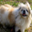

In [24]:
imgs_by_cat['dog'][1]

In [26]:
target_img = PIL.Image.open('../data/raw/cat_snow.jpg')

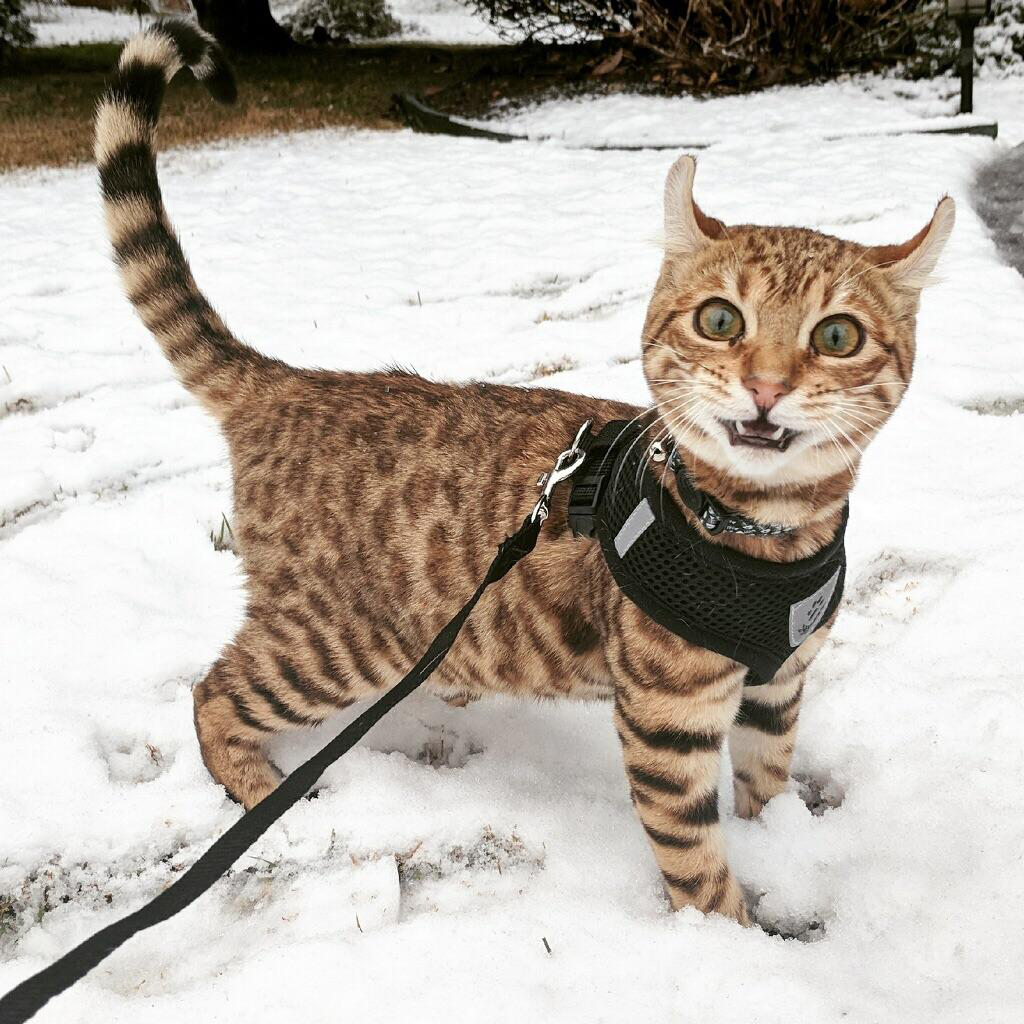

In [27]:
target_img

In [29]:
img = np.array(target_img)

In [33]:
img.shape

(1024, 1024, 3)

In [32]:
np.array(imgs_by_cat['dog'][1]).shape

(32, 32, 3)

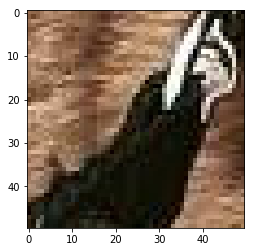

In [38]:
plt.imshow(img[500:550, 500:550])

In [48]:
img = np.array(imgs_by_cat['cat'][0])

In [49]:
result = []
size = 4
for i in range(img.shape[0] // size):
    result.append([])
    for j in range(img.shape[1] // size):
        img_slice = img[
            i * size : (i + 1) * size, 
            j * size : (j + 1) * size
        ] 
        result[-1].append(img_slice)

In [50]:
res = np.array(result)

In [57]:
res[0][0].reshape(-1, 3).mean(axis = 0)

array([153.5   , 152.375 , 149.3125])